# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones
# Materia: Aprendizaje Supervisado
**Trabajo Práctico Entregable**


**Kaggle Competition**


**Grupo 22. Integrantes:**
* Carazo, Fernando Diego
* Cardellino, Fernando.
* Ferrero, Nicolás.
* Molina, Florencia
* Pizarro, Rodrigo. 


**Consigna**

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en el ejemplo provisto por la cátedra.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn import ensemble

from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

# vemos la perdida de datos con la libreria missingno
import missingno as msno

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/train.csv')
print('El conjunto de datos tiene {0} columnas y {1} filas'.format(df.shape[0], df.shape[1]))
print(df.info())
df.describe().round(2) # solo variables continuas (tipo de dato entero y/o flotante)

El conjunto de datos tiene 7823 columnas y 14 filas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   7823 non-null   int64  
 1   HomePlanet    7644 non-null   object 
 2   CryoSleep     7627 non-null   object 
 3   Cabin         7639 non-null   object 
 4   Destination   7663 non-null   object 
 5   Age           7661 non-null   float64
 6   VIP           7639 non-null   object 
 7   RoomService   7669 non-null   float64
 8   FoodCourt     7668 non-null   float64
 9   ShoppingMall  7635 non-null   float64
 10  Spa           7665 non-null   float64
 11  VRDeck        7654 non-null   float64
 12  Name          7639 non-null   object 
 13  Transported   7823 non-null   int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 855.8+ KB
None


,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,7823.00,7661.00,7669.00,7668.00,7635.00,7665.00,7654.00,7823.00
mean,4345.69,28.88,226.08,455.64,172.60,305.02,295.48,0.51
std,2504.58,14.46,679.18,1621.29,597.92,1133.42,1093.49,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2182.50,19.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,4345.00,27.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,6515.50,38.00,44.00,69.00,28.00,58.00,46.00,1.00
max,8692.00,79.00,14327.00,29813.00,23492.00,22408.00,24133.00,1.00


### Identificación y breve análisis y descripción de las columnas del conjunto de datos

A continuación y en pos de analizar el conjunto de datos y las posibles transformaciones que deberán aplicarse para operar con diferentes modelos de ML, se procede a analizar cada variable.  
1. (1) PassengerId (Id del pasajero): ID único -numero identificatorio- del pasajero. Variable/índice que no debe tenerse en cuenta como una variable con un significado y/o "explicativa" de algo. TdD ==> ENTERA
2. (2) HomePlanet (planeta de origen del pasajero): lugar al que corresponde el registro. Toma tres valores: Europa, marte y tierra. Variable categórica ternaria. TdD ==> 'object' == 'STRING'
3. (3)  CryoSleep (sueño congelado / viaje congelado): indica si el pasajero realizó el viaje "congelado" (True) o no (False). Los pasajeros criogenados realizaron el viaje confinados en sus cabinas (datos de la web). Variable categórica binaria (booleana).
4. (4) Cabin (cabina): número de la cabina en la que el pasajero hizo el viaje. Tiene la forma "piso/número/lado". Para indicar el lado se emplea: 1- "P" para babor, y 2- "S" para estribor. TdD ==> 'object' == 'STRING'
5. (5) Destination (destino): planeta en el que desembarcará el pasajero. Variable cuyo significado/codificación no se entiende. Variable que toma 4 (cuatro valores diferentes). TdD ==> 'object' == 'STRING'.
6. (6) Age (edad): edad del pasajero.  TdD ==> 'float64'.
7. (7) VIP: si el pasajero pagó por un sevicio VIP durante el viaje. TdD ==> 'object' == 'STRING'.
8. (8) / 12 (8-12): RoomService (servicios de cuarto), FoodCourt (patios de comidas), ShoppingMall (shoppings), Spa (¿centro de relajación?) y VRDeck (¿?): montos que se les facturó al pasajero  en cada uno de los servicios de lujo del Titanic mencionados. TdD ==> float64.
13. (13) Name (nombre): nombre y apellido del pasajero. TdD ==> 'object' == 'STRING'
14. (14) Transported (transportado): variable objetivo/target que se desea predecir. Variable categórica binaria, toma dos valores: 0 (cero) y 1 (uno). 0 implica que el pasajero no fue transportado a otra dimensión, y 1 implica que el pasajero fue transportado a otra dimensión. TdD ==> ENTERA.

### Resumen de las variables

Las variables/features podrían agruparse en tres grupos, a saber:
1. Variables continuas:
    * Age
    * RoomService
    * FoodCourt
    * ShoppingMall
    * Spa
    * VRDeck
2. Variables categóricas:
    * HomePlanet
    * CryoSleep
    * Destination
    * VIP
3. Variables "informativas":
    * PassengerId
    * Cabin
    * Name

### Gráficas de las  variables
##### Variables continuas

<Figure size 7200x7200 with 0 Axes>

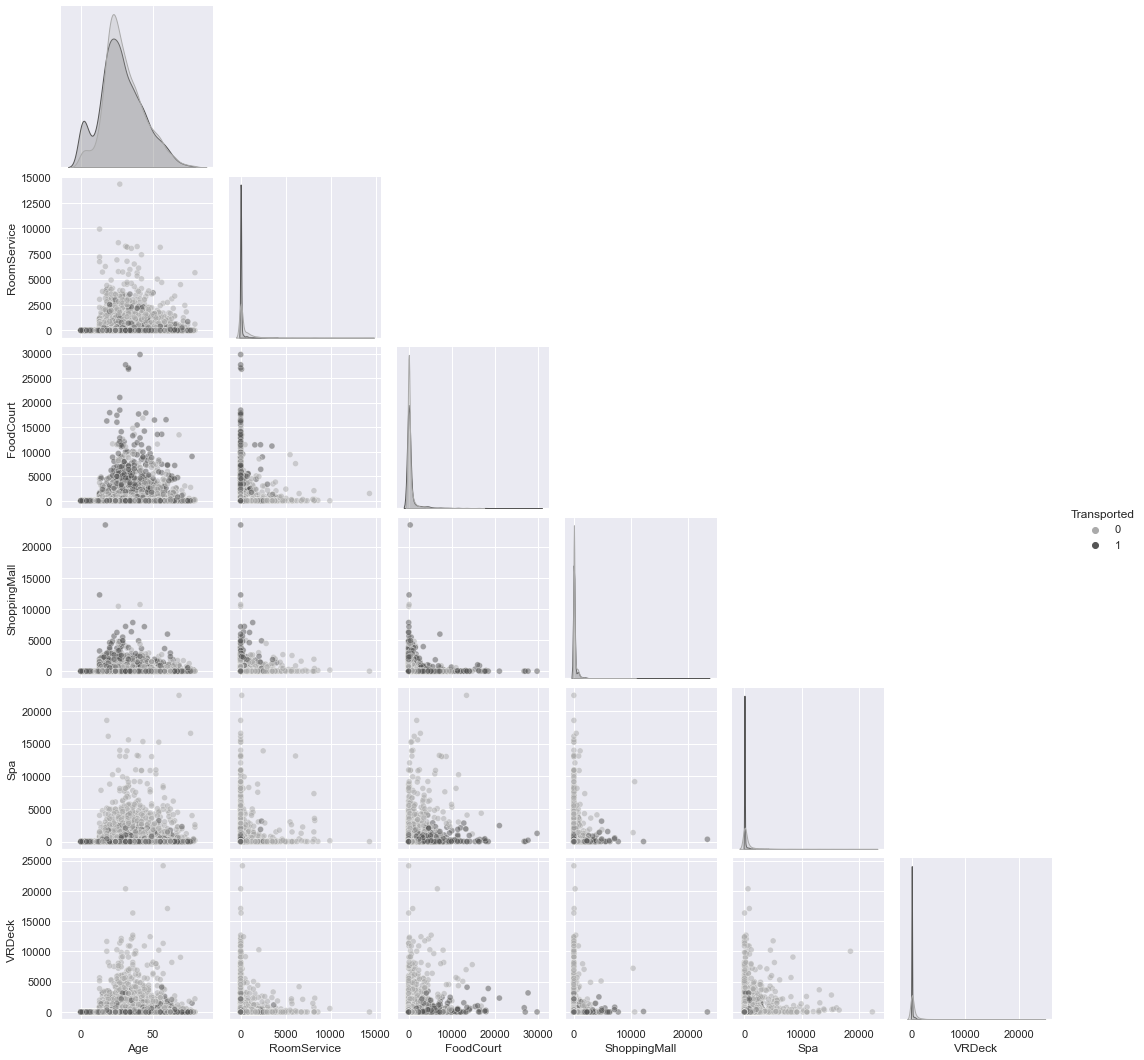

In [4]:
# iterating the columns
num_cols= list()
[num_cols.append(colname) for colname, coltype in df.dtypes.iteritems() if coltype == 'float']
num_cols_trans=num_cols.copy()
num_cols_trans.append('Transported')

# graficamos
fig= plt.figure(figsize=(100,100))
sns.plotting_context(font_scale=1.0)
sns.set(font_scale = 1.0)
sns.color_palette("pastel", as_cmap=True)

pg = sns.pairplot(df[num_cols_trans],
             diag_kind= 'kde',
             hue='Transported',
             # height= 1.0,
             # aspect= 1.0,
             corner= True,
             palette='gist_gray_r', # Turbo
             # kind= 'reg',
             markers='o',
             diag_kws= dict(shade=True),
             plot_kws={'alpha': 0.5}
             )
plt.show()

Con el fin de analizar con mayor detalle, a continuación se grafican las distribuciones de las variables continuas.

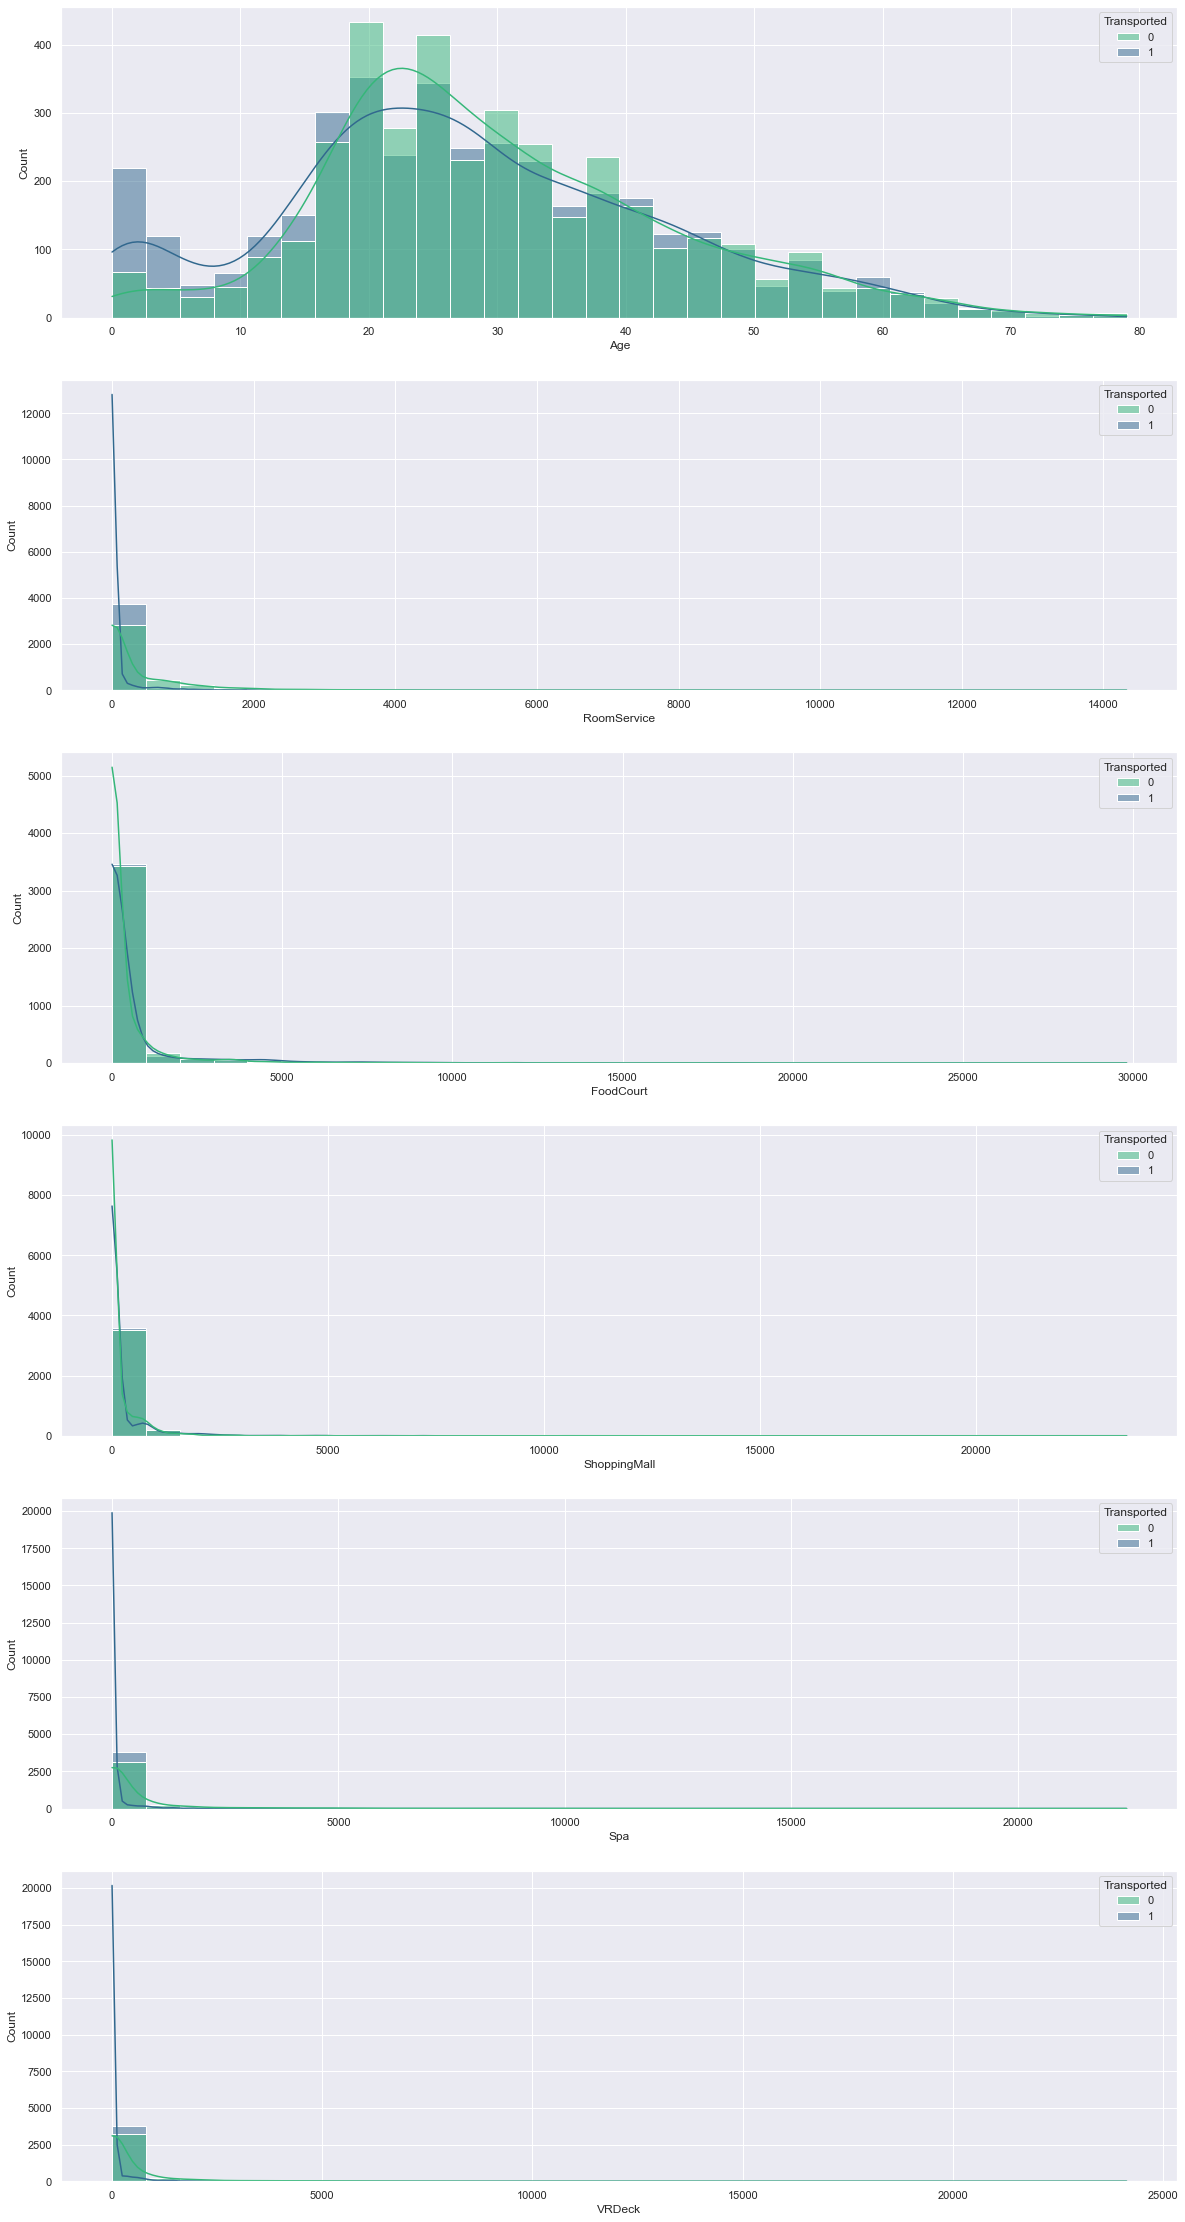

In [5]:
# graficamos
fig= plt.figure(figsize=(20,40))
sns.color_palette("pastel", as_cmap=True)

for i, col_name in enumerate(num_cols):
    ax= fig.add_subplot(len(num_cols), 1, i+1)
    sns.histplot(data=df[num_cols_trans],
                 x= col_name,
                 axes= ax,
                 bins=30,
                 kde= True,
                 palette='viridis_r', # Turbo
                 hue='Transported'
                )
    # ax.set_title(col_name)

plt.show()

###### Análisis de las variables continuas
1. Age: puede dividirse (a grandes rasgos) en tres grupos:
* 0-18 la mayoría fueron transportados.
* 18-25:  la mayoría no fueron  transportados.
* mayores de 25: aproximadamente igual cantidad de transportados que de no transportados.

Nota: un buen criterio para posteriormente correlacionar otras variables con las edades y los grupos transportados y no transportados, sería estratificar las personas por edad: niños, adolescentes y adultos.

2. El resto de las variables (FoodCourt, ShoppingMall, RoomService, Spa y VRDeck) presentan distribuciones y valores "aproximadamente" iguales. A partir de un primer análisis puede decirse que:
* La mayoría de la gente no gasta dinero.
* La distribución del gasto decae exponencialmente.
* La cantidad de datos atípicos son pocos.
* Las personas transportadas tienden "levemente" a gastar menos.
* RoomService, Spa y VRDeck tienen distribuciones que difieren levemente a las de FoodCourt y ShoppingMall (tienden a presentar valores de gastos más altos), con lo cual y en función del significado de las variables, se podría pensar que son un "lujo" frente a servicios esenciales o de distracción.

#### Variables Categóricas

In [7]:
cat_cols= ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
cat_cols_trans= cat_cols.copy()
cat_cols_trans.append('Transported')

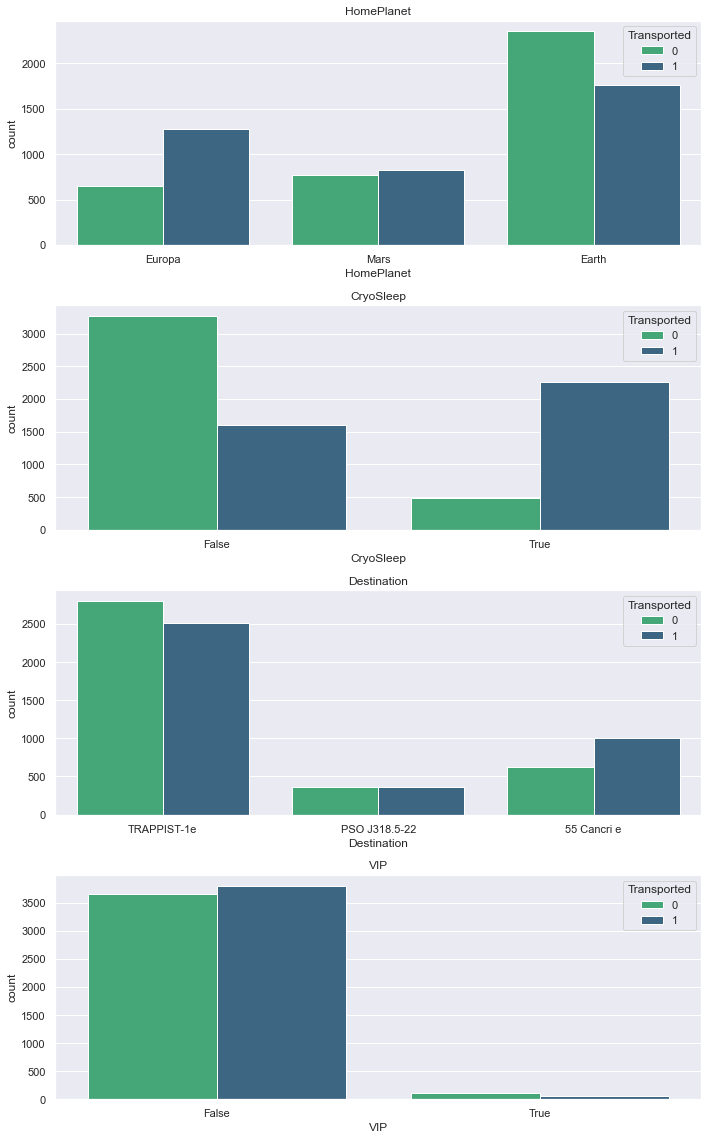

In [8]:
# plot categorical features-.
fig= plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_cols):
    ax= fig.add_subplot(len(cat_cols),1,i+1)
    sns.countplot(data=df[cat_cols_trans],
                  x=var_name,
                  axes=ax,
                  palette='viridis_r', # Turbo
                  hue='Transported'
                 )
    ax.set_title(var_name)

fig.tight_layout()  # improves appearance a bit-.
plt.show()

###### Análisis de las variables categóricas
En general y salvo la variable VIP, se aprecian diferencias en los valores de las variables para los distintos estados. Como se mencionó, la variable VIP no parece ser una característica útil ya que para los dos valores que toma la cantidad de transportados y no transportados toman valores semejantes. CryoSleep presenta un aspecto que la torna interesante para emplearla en el conjunto de entrenamiento. Como conlusión, en un estudio posterior podrían dejarse las variables HomePlanet, CryoSleep y Destination y eliminarse la variable VIP.

###### Análisis de las variables informativas/cualitativas
Antes de plotearlas las visualizamos:

In [7]:
df[inf_cols].head(5)

""
0
1
2
3
4


###### Análisis de las variables informativas/cualitativas
No tiene sentido plotearlas. En esta instancia (inicial) se procederá de la siguiente manera:
* Eliminar la variable PassangerId del PDF y almacenarla sola para su posterior uso o empleo.


Posteriormente podría:
* Eliminarse la variable Cabin o desglosarla en tres columnas: 1- piso, 2- número y 3- lado.
* Eliminar la variable Name (para anonimizar el DF, basta con PassangerId) o dejar solo apellido para llevar a cabo estudios y comprobaciones posteriores y su relacion con otras variables

### Análisis de datos faltantes

<AxesSubplot:>

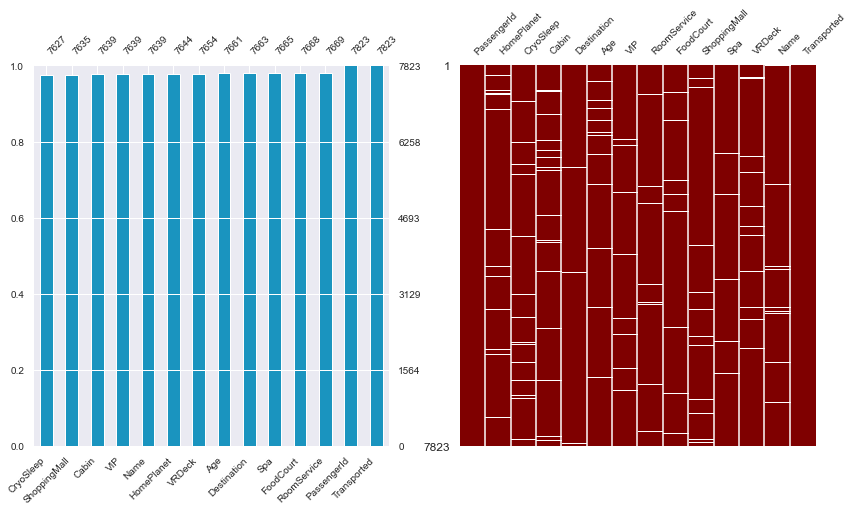

In [8]:
# unpack
figchar = (1, 2, 14, 7)
nr, nc, fig_width, fig_height = figchar

fig, ax = plt.subplots(nrows=nr, ncols=nc,
                       figsize=(fig_width, fig_height))
msno.bar(df, fontsize=10, sort='ascending',
         color=[0.1, 0.58, 0.75], ax=ax[0])  # total de datos
msno.matrix(df, sparkline=False, fontsize=10,
            color=[0.5, 0, 0], ax=ax[1])  # total de datos

# plt.suptitle(f'Datos perdidos')
# plt.tight_layout()

Vemos en valores lo graficado.

In [9]:
# Id de Columnas con valores faltantes-.
i_na_cols= df.columns[df.isna().any()].tolist()

# resumen de los valores faltantes en cada feature pra cada registro-.
res= pd.DataFrame(df[i_na_cols].isna().sum(), columns=['Cantidad_de_valores_faltantes'])
res['Porcentaje faltante (%)']= np.round(100*res['Cantidad_de_valores_faltantes']/len(df),2)
print(res)
print(round(df[i_na_cols].isna().sum().sum()/(df.shape[0]*df.shape[1])*100, 2))

              Cantidad_de_valores_faltantes  Porcentaje faltante (%)
HomePlanet                              179                     2.29
CryoSleep                               196                     2.51
Cabin                                   184                     2.35
Destination                             160                     2.05
Age                                     162                     2.07
VIP                                     184                     2.35
RoomService                             154                     1.97
FoodCourt                               155                     1.98
ShoppingMall                            188                     2.40
Spa                                     158                     2.02
VRDeck                                  169                     2.16
Name                                    184                     2.35
1.89


A partir de la figura se observa que, en general, los valores faltantes de las diferentes features son independientes de la variable objetivo o target y que la pérdida de datos es de tipo aleatoria; no existiendo, en general, una correlación entre los datos faltantes de las diferentes variables/features.

Por otro lado, cada feature tiene un % de valores faltantes de aproximadamente 2%. En tanto el porcentaje de datos faltantes del total del DF es 1.89%. La ùnica feature que no presenta valores faltantes es PasangerId.

Dado que la mayoría de los valores faltantes están aislados, tendría sentido imputarlos.

Nota: si se pretende maximizar las métricas de los modelos, debemos buscar patrones dentro de los valores de los features faltantes. La forma de hacerlo es observando la distribución conjunta de funciones, por ej. ¿los pasajeros de un mismo grupo provienen de la misma familia?.

### Verificamos y visualizamos el balanceo de la variable target u objetivo.

Text(0.5, 1.0, 'Transported')

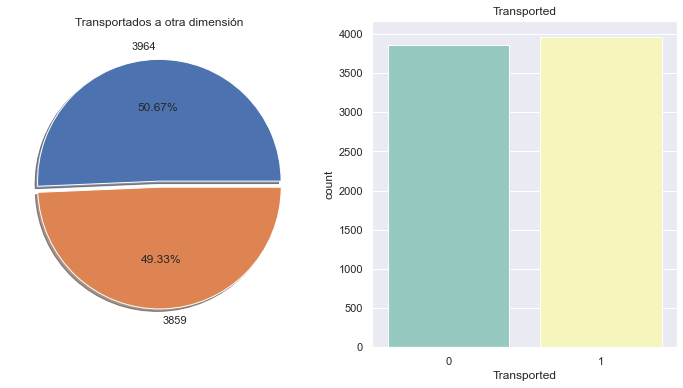

In [10]:
nrows= 1; ncols= 2
figure1, axes= plt.subplots(nrows, ncols, figsize=(12,6)) 
total= len(df['Transported'])
axes[0].pie(df['Transported'].value_counts(),
            labels= df['Transported'].value_counts(),
            autopct='%.2f%%',
            explode=[0.025,0.025],
            shadow=True
             )
sns.countplot(x='Transported',
              data=df,
              palette='Set3',
              ax= axes[1]
             )
axes[0].set_title('Transportados a otra dimensión')
axes[1].set_title('Transported')

Claramente la variable objetivo/Target está balanceada, motivo por el cual no deberemos aplicar técnicas de sub o sobre-muestreo.

## Curación

A partir del análisis desarrollado, procederemos a tratar los: 1) valores faltantes, y 2) a escalar y encodear:
1. Valores faltantes: se procede de la siguiente manera:
* variables categóricas: eliminamos los registros con valores faltantes (podría imputarse con la moda).
* variables continuas: imputamos con la mediana.
2. Encoding y escalado: se procede de la siguiente manera:
* variables categóricas: se aplica un encoding (LabelEncoder).
* variables continuas: se entandarizan.

#### Datos faltantes

In [11]:
# 1- variables continuas
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"] # Imputamos los datos faltantes de las columnas correspondientes a
                                                                                    # los "amenities" de la nave    
imputer = SimpleImputer(strategy="median")                                          # Imputamos por la mediana  
df[imputer_cols] = imputer.fit_transform(df[imputer_cols])

In [12]:
# 2- variables categóricas
df = df.dropna(axis=0, subset=['CryoSleep', 'VIP', 'HomePlanet', 'Destination'])
print(len(df.index)) # perdimos 600 datos, lo cual representa el 9% de los datos

7123


Separamos la variable/target de las variables de características/features

In [13]:
y = df.Transported 
X = df.drop('Transported',axis=1)
X

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,Landa Grifford
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey
5,7586,Earth,False,F/1553/S,PSO J318.5-22,23.0,False,90.0,4.0,0.0,7.0,588.0,Benda Dickley
6,2358,Mars,False,E/153/P,TRAPPIST-1e,29.0,False,834.0,0.0,28.0,117.0,41.0,Quid Dutte
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7817,2204,Earth,True,G/379/P,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,Dorene Boyersons
7819,2693,Earth,False,G/459/S,TRAPPIST-1e,44.0,False,0.0,0.0,744.0,62.0,3.0,Gabrie Reenez
7820,8076,Mars,True,F/1772/P,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,Panzel Ruity
7821,3829,Earth,False,E/253/P,TRAPPIST-1e,15.0,False,0.0,840.0,123.0,0.0,20.0,Belly Weavesend


### Operaciones de transformación
1. Como se mencionó, a las variables categóricas se las encodeará. Para evitar un crecimiento excesivo de las columnas del conjunto de datos que se empleará para entrenar el modelo, solo se considerarán las columnas cuyos valores únicos sea menor a 5 (cinco). 
2. Extraemos la columna de Id de los pasajeros.
3. Aplicamos una operación de transformación en las columnas "HomePlanet", "CryoSleep", "Destination" y "VIP".
4. Aplicamos una operación de normalización en las columnas del conjunto de datos obtenido.

In [14]:
# print(X)
# 1-
# elejimos y transformamos algunas variables (en su análisis fundamente sus decisiones)
for var in X:
    if X[var].dtype == 'object':
        unique_cases = X[var].unique() # devuelve valores unicos en la columna (valores no repetidos)
        if len(unique_cases) > 5:        
            print(var)      
            X.drop(var, inplace=True, axis=1)   # si la cantidad de casos unicos es mayor a 5, tira esa columna

# print(X)
# 2-
passengerId = X.PassengerId
X.drop('PassengerId',axis=1,inplace=True)   # tira la columna de identidad de pasajeros

# 3- 
# print(X.columns)
label_cols = ["HomePlanet", "CryoSleep", "Destination" ,"VIP"]    

for col in label_cols:
    X[col] = X[col].astype(str)                   # convierte a string los valores de las columnas
    X[col] = LabelEncoder().fit_transform(X[col]) # hace label encoder sobre las columnas 
# print(X)

## X

# 4- apply StandardScalar
x_names = X.columns                      
X = StandardScaler().fit_transform(X)     # aplico StandardScaler a las columnas -ero-mean and unit variance-. 
X = pd.DataFrame(X, columns=x_names)
# X
# al final tenemos una base de datos con las variables categoricas con encoding y escaladas 

Cabin
Name


### Armamos los conjuntos de datos de entrenamiento y test a partir del conjunto de datos de entrenamiento

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

### Planteo modelos
Tienen que elegir los 2 mejores modelos así que prueben con varios.

In [16]:
clfs = [ensemble.RandomForestClassifier(random_state=0),
        linear_model.LogisticRegressionCV(solver='sag',
                                          max_iter=3000,
                                          random_state=0),
        linear_model.SGDClassifier(random_state=0), 
        SVC(kernel='poly',
            random_state=0),
        NuSVC(kernel='poly',
              random_state=0),
        LinearSVC(max_iter=50000,
                  random_state=0),
        DecisionTreeClassifier(criterion='entropy',
                               random_state=0), 
        ExtraTreeClassifier(random_state=0),
        XGBClassifier(random_state=0)
       ]

scores = [] # [None]#*len(clfs)
times = [] # [None]#*len(clfs)
clf_labels= list()

for i_clf, clf in enumerate(clfs):
    start_time = time.time()
    clf_fit = clf.fit(x_train,y_train)
    score = clf_fit.score(x_test,y_test)
    scores= np.append(scores,np.round(score,3))
    times= np.append(times, np.round((time.time() -start_time),2))
    
    # print("--- %s seconds ---" % (time.time() - start_time))
    print("--- %s seconds ---" % (times[i_clf]))
    
    train_predictions = clf_fit.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {clf}: %.2f%%" % (accuracy * 100.0))
    
    train_predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, train_predictions)
    print(f"Accuracy test {clf}: %.2f%%" % (accuracy * 100.0))

    clf_labels.append(clf.__class__.__name__)

    
    print('La accuracy de',  clf.__class__.__name__, 'es', score, '\n')

--- 0.57 seconds ---
Accuracy train RandomForestClassifier(random_state=0): 93.45%
Accuracy test RandomForestClassifier(random_state=0): 78.11%
La accuracy de RandomForestClassifier es 0.7810526315789473 

--- 0.75 seconds ---
Accuracy train LogisticRegressionCV(max_iter=3000, random_state=0, solver='sag'): 78.40%
Accuracy test LogisticRegressionCV(max_iter=3000, random_state=0, solver='sag'): 77.19%
La accuracy de LogisticRegressionCV es 0.7719298245614035 

--- 0.03 seconds ---
Accuracy train SGDClassifier(random_state=0): 79.10%
Accuracy test SGDClassifier(random_state=0): 77.68%
La accuracy de SGDClassifier es 0.7768421052631579 

--- 1.34 seconds ---
Accuracy train SVC(kernel='poly', random_state=0): 78.76%
Accuracy test SVC(kernel='poly', random_state=0): 77.26%
La accuracy de SVC es 0.7726315789473684 

--- 1.75 seconds ---
Accuracy train NuSVC(kernel='poly', random_state=0): 79.36%
Accuracy test NuSVC(kernel='poly', random_state=0): 77.05%
La accuracy de NuSVC es 0.770526315789

In [17]:
columns = ['Accuracy', 'Execution Time [s]']
acc = pd.DataFrame(data = np.array([scores,times]).T,
                   index = clf_labels,
                   columns = columns)
acc.sort_values(by='Accuracy', ascending=False)

,Accuracy,Execution Time [s]
XGBClassifier,0.789,0.34
RandomForestClassifier,0.781,0.57
SGDClassifier,0.777,0.03
SVC,0.773,1.34
LogisticRegressionCV,0.772,0.75
NuSVC,0.771,1.75
LinearSVC,0.764,0.76
DecisionTreeClassifier,0.760,0.02
ExtraTreeClassifier,0.752,0.00


A coninutación realizaremos el ajuste de hiperparámetros de los tres primeros modelos, que cuentan con el mejor Accuracy score:
1. XGB
2. Random Forest
3. SGD

### Proponemos un ajuste de hiperparámetros de los modelos elegidos

In [18]:
gridRF = GridSearchCV(ensemble.RandomForestClassifier(random_state=0),
                      {'criterion':('gini','entropy', 'log_loss'),
                       'max_depth':(10,20,100,500)})
gridRF.fit(x_train,y_train)
gridRF.best_params_

{'criterion': 'gini', 'max_depth': 10}

Accuracy train RF: 85.38%
Accuracy test RF: 79.37%


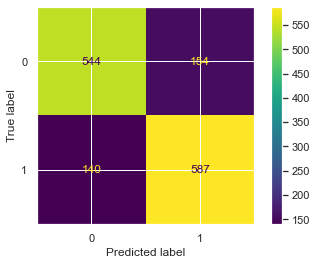

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       698
           1       0.79      0.81      0.80       727

    accuracy                           0.79      1425
   macro avg       0.79      0.79      0.79      1425
weighted avg       0.79      0.79      0.79      1425



In [19]:
clfRF = ensemble.RandomForestClassifier(**gridRF.best_params_,random_state=0).fit(x_train, y_train)

train_predictions = clfRF.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train RF: %.2f%%" % (accuracy * 100.0))

test_predictions = clfRF.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test RF: %.2f%%" % (accuracy * 100.0))
cm=confusion_matrix(y_test,test_predictions,labels=clfRF.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clfRF.classes_)
disp.plot()
plt.show()

print(classification_report(y_test,clfRF.predict(x_test)))

In [20]:
gridSGD =GridSearchCV(linear_model.SGDClassifier(random_state=0),
                      {'loss': ['hinge', 'log', 'epsilon_insensitive'], # linar SVM, log_loss: logRegression-.
                       'penalty': ['l2', 'l1', 'elasticnet'],
                       'alpha': [1.0e-5, 1.0e-4, 1.0e-3], # regularization and TasaDeAprend == learning rate-.
                       'max_iter': [1e+6], # number of epochs-.
                       'power_t': [5.0e-1],
                       'learning_rate' : ['optimal'], # learning rate
                       'n_jobs': [-1]
                      })
gridSGD.fit(x_train,y_train)
gridSGD.best_params_

{'alpha': 0.001,
 'learning_rate': 'optimal',
 'loss': 'log',
 'max_iter': 1000000.0,
 'n_jobs': -1,
 'penalty': 'l1',
 'power_t': 0.5}

Accuracy train SGD: 78.17%
Accuracy test SGD: 76.56%


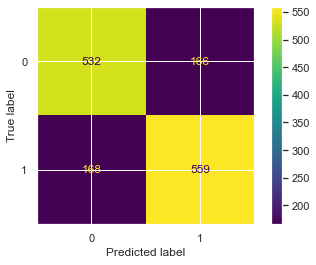

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       698
           1       0.77      0.77      0.77       727

    accuracy                           0.77      1425
   macro avg       0.77      0.77      0.77      1425
weighted avg       0.77      0.77      0.77      1425



In [21]:
clfSGD = linear_model.SGDClassifier(**gridSGD.best_params_,random_state=0).fit(x_train, y_train)

train_predictions = clfSGD.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train SGD: %.2f%%" % (accuracy * 100.0))

test_predictions = clfSGD.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test SGD: %.2f%%" % (accuracy * 100.0))
cm=confusion_matrix(y_test,test_predictions,labels=clfSGD.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clfSGD.classes_)
disp.plot()
plt.show()

print(classification_report(y_test,clfSGD.predict(x_test)))

In [22]:
estimator = XGBClassifier(eval_metric='mlogloss',random_state=0)
n_estimators = [50, 150, 200, 250, 300]
max_depth = [1,3,5,7,9]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2]
# eval_metric = 
# min_child_weight = range(1,6,2) 
# reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', 
                                 n_jobs=None, cv=None, verbose=4, refit=True)
grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.716 total time=   0.0s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.742 total time=   0.0s
[CV 3/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.701 total time=   0.0s
[CV 4/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.738 total time=   0.0s
[CV 5/5] END learning_rate=0.0001, max_depth=1, n_estimators=50;, score=0.721 total time=   0.0s
[CV 1/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.716 total time=   0.1s
[CV 2/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.742 total time=   0.1s
[CV 3/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.701 total time=   0.1s
[CV 4/5] END learning_rate=0.0001, max_depth=1, n_estimators=150;, score=0.738 total time=   0.1s
[CV 5/5] END learning_rate=0.0001, max_depth=1, n_estimators

[CV 5/5] END learning_rate=0.0001, max_depth=7, n_estimators=150;, score=0.786 total time=   0.6s
[CV 1/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.756 total time=   0.8s
[CV 2/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.780 total time=   0.8s
[CV 3/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.779 total time=   0.8s
[CV 4/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.775 total time=   0.8s
[CV 5/5] END learning_rate=0.0001, max_depth=7, n_estimators=200;, score=0.786 total time=   0.8s
[CV 1/5] END learning_rate=0.0001, max_depth=7, n_estimators=250;, score=0.756 total time=   1.0s
[CV 2/5] END learning_rate=0.0001, max_depth=7, n_estimators=250;, score=0.780 total time=   1.0s
[CV 3/5] END learning_rate=0.0001, max_depth=7, n_estimators=250;, score=0.779 total time=   1.1s
[CV 4/5] END learning_rate=0.0001, max_depth=7, n_estimators=250;, score=0.777 total time=   1.1s
[CV 5/5] END learnin

[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=250;, score=0.738 total time=   0.5s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.754 total time=   0.6s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.777 total time=   0.6s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.742 total time=   0.6s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.779 total time=   0.6s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=300;, score=0.757 total time=   0.6s
[CV 1/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.753 total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.778 total time=   0.1s
[CV 3/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.761 total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=5, n_estimators=50;, score=0.768 total time=   0.1s
[CV 5/5] END learning_rate=0.001, 

[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=50;, score=0.721 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.716 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.742 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.701 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.738 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=150;, score=0.721 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=0.716 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=0.742 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=0.701 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=200;, score=0.738 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_dept

[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=250;, score=0.785 total time=   1.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=250;, score=0.802 total time=   1.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=250;, score=0.788 total time=   1.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=250;, score=0.814 total time=   1.1s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=250;, score=0.787 total time=   1.1s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.783 total time=   1.3s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.806 total time=   1.4s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.789 total time=   1.2s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.815 total time=   1.2s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=300;, score=0.789 total time=   1.3s
[CV 1/5] END learning_rate=0.01, max_dep

[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.808 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=50;, score=0.798 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.786 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.797 total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.777 total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.810 total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=0.798 total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.785 total time=   0.5s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.796 total time=   0.5s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.778 total time=   0.5s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estim

[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.778 total time=   0.3s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.792 total time=   0.3s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.780 total time=   0.3s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.798 total time=   0.3s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=250;, score=0.793 total time=   0.3s
[CV 1/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.779 total time=   0.4s
[CV 2/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.793 total time=   0.3s
[CV 3/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.780 total time=   0.4s
[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.799 total time=   0.3s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=300;, score=0.793 total time=   0.3s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_est

[CV 3/5] END learning_rate=0.2, max_depth=9, n_estimators=50;, score=0.771 total time=   0.2s
[CV 4/5] END learning_rate=0.2, max_depth=9, n_estimators=50;, score=0.796 total time=   0.2s
[CV 5/5] END learning_rate=0.2, max_depth=9, n_estimators=50;, score=0.786 total time=   0.2s
[CV 1/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.773 total time=   0.6s
[CV 2/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.794 total time=   0.7s
[CV 3/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.767 total time=   0.7s
[CV 4/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.796 total time=   0.6s
[CV 5/5] END learning_rate=0.2, max_depth=9, n_estimators=150;, score=0.777 total time=   0.8s
[CV 1/5] END learning_rate=0.2, max_depth=9, n_estimators=200;, score=0.775 total time=   1.0s
[CV 2/5] END learning_rate=0.2, max_depth=9, n_estimators=200;, score=0.792 total time=   1.0s
[CV 3/5] END learning_rate=0.2, max_depth=9, n_estima

Accuracy train XGB: 81.94%
Accuracy test XGB: 79.02%


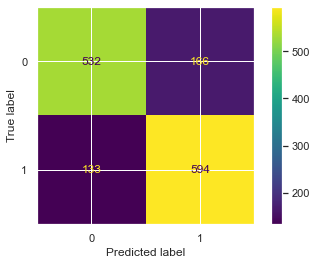

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       698
           1       0.78      0.82      0.80       727

    accuracy                           0.79      1425
   macro avg       0.79      0.79      0.79      1425
weighted avg       0.79      0.79      0.79      1425



In [23]:
clf = XGBClassifier(**grid_result.best_params_, random_state=0).fit(x_train, y_train)

train_predictions = clf.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train XGB: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test XGB: %.2f%%" % (accuracy * 100.0))
cm=confusion_matrix(y_test,test_predictions,labels=clf.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

print(classification_report(y_test,clf.predict(x_test)))

In [24]:
names = ['Random Forest','SGDC','XGB']

FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train)
y_train2 = np.array(y_train)


for clfi, name in zip([ensemble.RandomForestClassifier(**gridRF.best_params_,random_state=0),
                       linear_model.SGDClassifier(**gridSGD.best_params_,random_state=0), 
                       XGBClassifier(**grid_search.best_params_,random_state=0)],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100 :.2f}')

RandomForestClassifier(max_depth=10, random_state=0)
Precisión test fold 0: 77.81
Precisión test fold 1: 80.88
Precisión test fold 2: 79.04
Precisión test fold 3: 79.10
Precisión test fold 4: 80.68
Avg. accuracy = 79.50
SGDClassifier(alpha=0.001, loss='log', max_iter=1000000.0, n_jobs=-1,
              penalty='l1', random_state=0)
Precisión test fold 0: 77.37
Precisión test fold 1: 79.65
Precisión test fold 2: 77.37
Precisión test fold 3: 78.75
Precisión test fold 4: 78.67
Avg. accuracy = 78.36
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=

## Generar la salida para entregar

In [25]:
test_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/test.csv')

In [26]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,Europa,True,NaN,55 Cancri e,34.0,False,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,Earth,True,G/1489/S,PSO J318.5-22,13.0,False,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,Earth,False,G/776/P,TRAPPIST-1e,44.0,False,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,Earth,False,E/577/S,PSO J318.5-22,63.0,False,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,Europa,False,B/117/S,55 Cancri e,10.0,False,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,5996,Mars,False,F/1212/S,TRAPPIST-1e,54.0,False,676.0,0.0,231.0,379.0,0.0,Anch Perta
866,5478,Earth,True,G/947/S,TRAPPIST-1e,58.0,False,0.0,0.0,0.0,0.0,0.0,Hughy Hessey
867,6760,Earth,True,G/1148/P,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Heidie Kimpson
868,1437,Earth,False,F/293/S,TRAPPIST-1e,18.0,False,765.0,0.0,13.0,0.0,0.0,Herina Oconley


Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [27]:
# no se eliminan nulos para no eliminar filas ya que par poder subir el archivo a kaggle se necesita contar con 870 filas
# test_df = test_df.dropna(axis=0, subset=['CryoSleep', 'VIP', 'HomePlanet', 'Destination'])

In [28]:
test_df[imputer_cols] = imputer.fit_transform(test_df[imputer_cols])

PassengerId = test_df['PassengerId']
test_df.drop(['PassengerId','Cabin', 'Name'], inplace=True, axis=1)

for col in label_cols:
    test_df[col] = test_df[col].astype(str)
    test_df[col] = LabelEncoder().fit_transform(test_df[col])

cols = test_df.columns
test_df = StandardScaler().fit_transform(test_df)
test_df = pd.DataFrame(test_df, columns=cols)

Generamos la salida

In [29]:
test_id = PassengerId
test_pred = clf.predict(test_df)

In [30]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv("sample_submission.csv", header=True, index=False)
submission

,PassengerId,Transported
0,415,1
1,8663,1
2,4524,0
3,8246,0
4,2935,1
...,...,...
865,5996,0
866,5478,1
867,6760,1
868,1437,0
